Nama : FITROTUL FAIZAH

NIM : 22.11.5021

PROYEK DATA MINING

JUDUL : Prediksi Tipe Kepribadian MBTI berdasarkan Data Teks menggunakan SVM

In [ ]:
# Install & Import Library
!pip install joblib
!pip install imbalanced-learn
!pip install streamlit
!pip install nltk

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
import joblib
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
import io
import csv

In [ ]:
df = pd.read_csv('/content/mbti_1.csv')
df.head()

,type,posts
0,INFJ,http://www.youtube.com/watch?v=qsXHcwe3krw|||h...
1,ENTP,'I'm finding the lack of me in these posts ver...
2,INTP,'Good one _____ https://www.youtube.com/wat...
3,INTJ,"'Dear INTP, I enjoyed our conversation the o..."
4,ENTJ,'You're fired.|||That's another silly misconce...


## PREPROCESSING

In [ ]:
# Menampilkan informasi struktur dataset
print(df.info())
print(df['type'].value_counts())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8675 entries, 0 to 8674
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   type    8675 non-null   object
 1   posts   8675 non-null   object
dtypes: object(2)
memory usage: 135.7+ KB
None
type
INFP    1832
INFJ    1470
INTP    1304
INTJ    1091
ENTP     685
ENFP     675
ISTP     337
ISFP     271
ENTJ     231
ISTJ     205
ENFJ     190
ISFJ     166
ESTP      89
ESFP      48
ESFJ      42
ESTJ      39
Name: count, dtype: int64


In [ ]:
# Menampilkan jumlah missing values di setiap kolom
print("Jumlah Missing Values per Kolom:")
print(df.isnull().sum())

Jumlah Missing Values per Kolom:
type     0
posts    0
dtype: int64


In [ ]:
# Menghapus URL
df['posts'] = df['posts'].apply(lambda x: re.sub(r'https?://[^\s]+', ' ', x))
print("Setelah menghapus URL:")
print(df['posts'].head(2))

# Menghapus angka dan karakter non-alfabet
df['posts'] = df['posts'].apply(lambda x: re.sub(r'[0-9]', ' ', x))
df['posts'] = df['posts'].apply(lambda x: re.sub(r'\W+', ' ', x))
df['posts'] = df['posts'].apply(lambda x: re.sub(r'[_+]', ' ', x))
print("Setelah menghapus angka dan karakter non-alfabet:")
print(df['posts'].head(2))

# Menghapus spasi berlebih
df['posts'] = df['posts'].apply(lambda x: re.sub(r'\s+', ' ', x))
print("Setelah menghapus spasi berlebih:")
print(df['posts'].head(2))

# Menghapus stopwords
nltk.download('stopwords')
remove_words = stopwords.words("english")
df['posts'] = df['posts'].apply(lambda x: x.lower())
df['posts'] = df['posts'].apply(lambda x: " ".join([w for w in x.split() if w not in remove_words and len(w) > 2]))
print("Setelah menghapus stopwords:")
print(df['posts'].head(2))

# Lemmatization
nltk.download('wordnet')
lemmatizer = WordNetLemmatizer()
df['posts'] = df['posts'].apply(lambda x: " ".join([lemmatizer.lemmatize(w) for w in x.split()]))
print("Setelah lemmatization:")
print(df['posts'].head(2))

!pip install symspellpy
from symspellpy.symspellpy import SymSpell, Verbosity

# Inisialisasi SymSpell
sym_spell = SymSpell(max_dictionary_edit_distance=2, prefix_length=7)

# Download manual jika belum ada file
dictionary_path = "frequency_dictionary_en_82_765.txt"
term_index = 0  # kolom pertama = kata
count_index = 1  # kolom kedua = frekuensi
sym_spell.load_dictionary(dictionary_path, term_index, count_index)

# Fungsi autocorrect untuk 1 kalimat
def correct_sentence(text):
    corrected = []
    for word in text.split():
        suggestions = sym_spell.lookup(word, Verbosity.CLOSEST, max_edit_distance=2)
        if suggestions:
            corrected.append(suggestions[0].term)
        else:
            corrected.append(word)
    return ' '.join(corrected)

# Terapkan autocorrect
df['posts'] = df['posts'].apply(correct_sentence)

print("Setelah SymSpell Autocorrect:")
print(df['posts'].head(2))

# Rename kolom cleaned_text
df.rename(columns={'posts': 'cleaned_text'}, inplace=True)

# 9. Simpan hasil preprocessing ke file baru
df.to_csv('mbti_preprocessed.csv', index=False)
print("✅ Dataset berhasil disimpan sebagai 'mbti_preprocessed.csv'")

Setelah menghapus URL:
0      and intj momants     sportscenter not top te...
1    'I'm finding the lack of me in these posts ver...
Name: posts, dtype: object
Setelah menghapus angka dan karakter non-alfabet:
0     and intj momants sportscenter not top ten pla...
1     I m finding the lack of me in these posts ver...
Name: posts, dtype: object
Setelah menghapus spasi berlebih:
0     and intj momants sportscenter not top ten pla...
1     I m finding the lack of me in these posts ver...
Name: posts, dtype: object


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Setelah menghapus stopwords:
0    intj momants sportscenter top ten plays pranks...
1    finding lack posts alarming sex boring positio...
Name: posts, dtype: object


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Setelah lemmatization:
0    intj momants sportscenter top ten play prank l...
1    finding lack post alarming sex boring position...
Name: posts, dtype: object
Setelah SymSpell Autocorrect:
0    into moments sportscaster top ten play prank l...
1    finding lack post alarming sex boring position...
Name: posts, dtype: object
✅ Dataset berhasil disimpan sebagai 'mbti_preprocessed.csv'


In [ ]:
# Contoh teks hasil cleaning
print("\nContoh teks hasil cleaning:")
print(df['cleaned_text'].iloc[7])


Contoh teks hasil cleaning:
tend build collection thing desktop use frequently move folder called everything get sorted type sub type ike collect odd object even work lot people would call junk like collect old unused software ill take hand bunch old adobe think quite normal tend see friend real life every couple month said earlier people done get good one edit mostly mean tolerate sleep dreaming another form awake many layer thought sleep keep night edit sometimes scared thanks wish free follow interest desired feel though wish meant impossible thing seeing mean visual interpreting seeing mentally understanding concept hello feel though incapable creating anything wish could cant stand interviewer christ laugh into hmm would interesting see into show doubt would interesting general public though know think sound like one think sound like require input others know question its lean towards alternative rock type music answer well went page sorted song genre style sometimes look people 

## EDA

<ipython-input-9-4108065691>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x='type', data=df, order=df['type'].value_counts().index, palette='coolwarm')


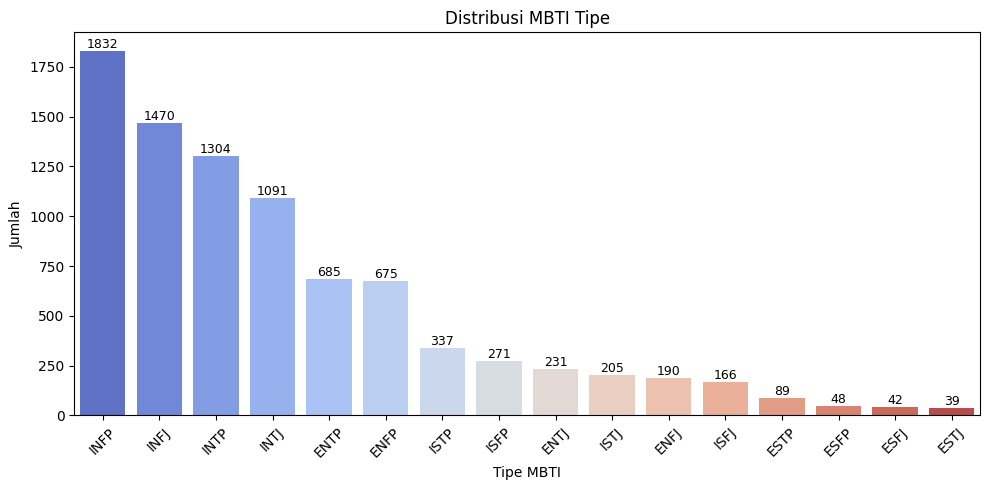

In [ ]:
# Menampilkan distribusi frekuensi masing-masing tipe MBTI
plt.figure(figsize=(10, 5))
ax = sns.countplot(x='type', data=df, order=df['type'].value_counts().index, palette='coolwarm')
plt.title("Distribusi MBTI Tipe")
plt.xlabel("Tipe MBTI")
plt.ylabel("Jumlah")
plt.xticks(rotation=45)

# Menambahkan label count di atas setiap bar
for p in ax.patches:
    count = int(p.get_height())
    ax.annotate(f'{count}', (p.get_x() + p.get_width() / 2., count),
                ha='center', va='bottom', fontsize=9, color='black')

plt.tight_layout()
plt.show()

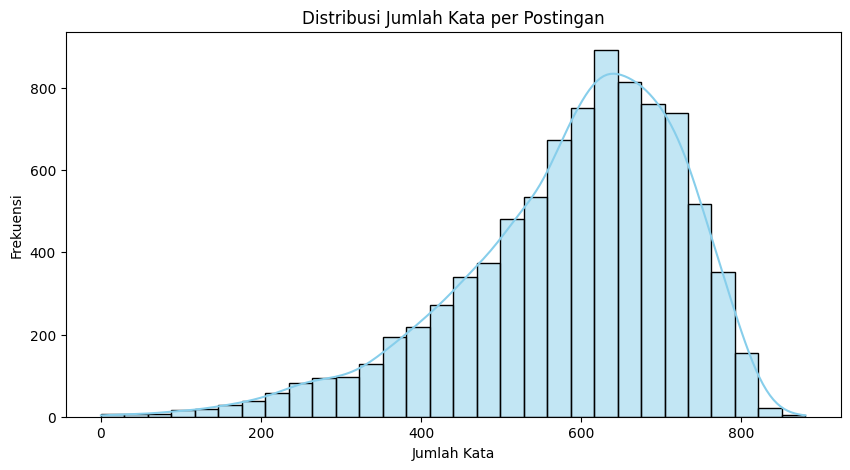

In [ ]:
# Menambahkan kolom jumlah kata per postingan
df['word_count'] = df['cleaned_text'].apply(lambda x: len(x.split()))

# Visualisasi distribusi panjang postingan
plt.figure(figsize=(10, 5))
sns.histplot(df['word_count'], bins=30, kde=True, color='skyblue')
plt.title("Distribusi Jumlah Kata per Postingan")
plt.xlabel("Jumlah Kata")
plt.ylabel("Frekuensi")
plt.show()

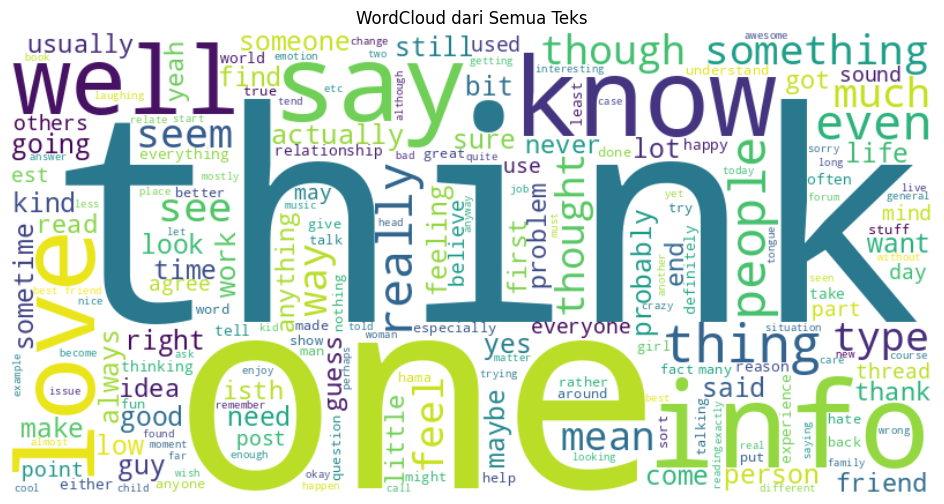

In [ ]:
# WordCloud dari seluruh teks
all_words = ' '.join(df['cleaned_text'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_words)
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("WordCloud dari Semua Teks")
plt.show()

## FEATURE SELECTION, FEATURE EXTRACTION & MODELLING

In [ ]:
# Tambahkan kolom label per dimensi
df['IE'] = df['type'].apply(lambda x: x[0])
df['NS'] = df['type'].apply(lambda x: x[1])
df['TF'] = df['type'].apply(lambda x: x[2])
df['JP'] = df['type'].apply(lambda x: x[3])

# Fungsi training model per dimensi
def train_binary_model(texts, labels):
    vectorizer = TfidfVectorizer(max_features=7000, ngram_range=(1,3))
    X = vectorizer.fit_transform(texts)
# Encode Label
    le = LabelEncoder()
    y = le.fit_transform(labels)
# Split & Smote
    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)
    smote = SMOTE(random_state=42)
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
# Feature Selection
    selector = SelectKBest(score_func=chi2, k=5000)
    X_train_selected = selector.fit_transform(X_train_resampled, y_train_resampled)
    X_test_selected = selector.transform(X_test)

    param_grid = {
        'C': [0.1, 1, 10],
        'max_iter': [5000, 10000]
    }

    svm = LinearSVC(class_weight='balanced')
    cv = StratifiedKFold(n_splits=5)
    grid = GridSearchCV(svm, param_grid, cv=cv, scoring='accuracy', n_jobs=-1)
    grid.fit(X_train_selected, y_train_resampled)
    best_model = grid.best_estimator_

    y_pred = best_model.predict(X_test_selected)
    print(classification_report(y_test, y_pred, target_names=le.classes_))
    print("Accuracy:", accuracy_score(y_test, y_pred))

    return {
        'model': best_model,
        'vectorizer': vectorizer,
        'selector': selector,
        'label_encoder': le
    }

# Training semua dimensi
print("\n===== Dimensi I/E =====")
model_IE = train_binary_model(df['cleaned_text'], df['IE'])

print("\n===== Dimensi N/S =====")
model_NS = train_binary_model(df['cleaned_text'], df['NS'])

print("\n===== Dimensi T/F =====")
model_TF = train_binary_model(df['cleaned_text'], df['TF'])

print("\n===== Dimensi J/P =====")
model_JP = train_binary_model(df['cleaned_text'], df['JP'])

# Gabungkan ke dalam satu model
full_mbti_model = {
    'IE': model_IE,
    'NS': model_NS,
    'TF': model_TF,
    'JP': model_JP
}

joblib.dump(full_mbti_model, 'mbti_binary_model_bundle.pkl')


===== Dimensi I/E =====
              precision    recall  f1-score   support

           E       0.47      0.45      0.46       400
           I       0.84      0.85      0.84      1335

    accuracy                           0.76      1735
   macro avg       0.65      0.65      0.65      1735
weighted avg       0.75      0.76      0.75      1735

Accuracy: 0.7550432276657061

===== Dimensi N/S =====
              precision    recall  f1-score   support

           N       0.92      0.94      0.93      1496
           S       0.57      0.50      0.53       239

    accuracy                           0.88      1735
   macro avg       0.75      0.72      0.73      1735
weighted avg       0.87      0.88      0.88      1735

Accuracy: 0.8789625360230547

===== Dimensi T/F =====
              precision    recall  f1-score   support

           F       0.87      0.84      0.86       939
           T       0.82      0.86      0.84       796

    accuracy                           0.85      

['mbti_binary_model_bundle.pkl']

# EVALUASI MODEL #


=== EVALUASI GABUNGAN 16 TIPE MBTI ===
              precision    recall  f1-score   support

        ENFJ       0.55      0.70      0.61       190
        ENFP       0.77      0.70      0.74       675
        ENTJ       0.63      0.68      0.65       231
        ENTP       0.80      0.76      0.78       685
        ESFJ       0.47      0.40      0.44        42
        ESFP       0.45      0.42      0.43        48
        ESTJ       0.36      0.44      0.40        39
        ESTP       0.60      0.66      0.63        89
        INFJ       0.81      0.77      0.79      1470
        INFP       0.82      0.82      0.82      1832
        INTJ       0.76      0.76      0.76      1091
        INTP       0.76      0.83      0.80      1304
        ISFJ       0.66      0.66      0.66       166
        ISFP       0.75      0.70      0.72       271
        ISTJ       0.68      0.67      0.68       205
        ISTP       0.78      0.74      0.76       337

    accuracy                           0

<Figure size 1200x1200 with 0 Axes>

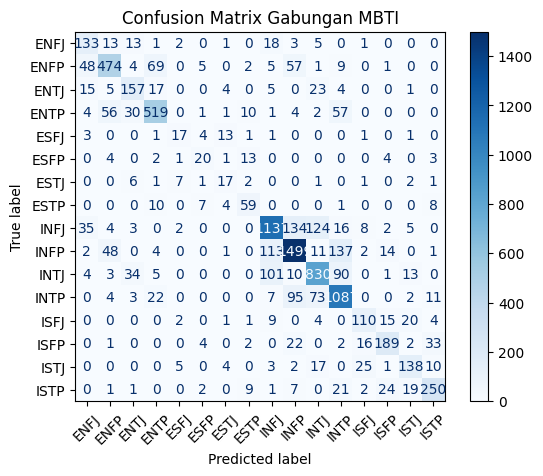

In [ ]:
# EVALUASI MODEL (PER DIMENSI DAN GABUNGAN)

# Prediksi semua baris pada dataset

def predict_all_mbti(df, model_bundle):
    predictions = []
    for text in df['cleaned_text']:
        mbti = ''
        for dim in ['IE', 'NS', 'TF', 'JP']:
            bundle = model_bundle[dim]
            vec = bundle['vectorizer'].transform([text])
            vec = bundle['selector'].transform(vec)
            pred = bundle['model'].predict(vec)
            label = bundle['label_encoder'].inverse_transform(pred)[0]
            mbti += label
        predictions.append(mbti)
    return predictions

# Evaluasi akhir gabungan 16 tipe
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

print("\n=== EVALUASI GABUNGAN 16 TIPE MBTI ===")
y_true = df['type']
y_pred = predict_all_mbti(df, full_mbti_model)
print(classification_report(y_true, y_pred))

# Confusion matrix
all_types = sorted(df['type'].unique())
cm = confusion_matrix(y_true, y_pred, labels=all_types)
plt.figure(figsize=(12, 12))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=all_types)
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title("Confusion Matrix Gabungan MBTI")
plt.show()

# PENYIMPANAN MODEL

In [ ]:
class MBTIPredictor:
    def __init__(self, model_bundle):
        self.model_bundle = model_bundle  # model_bundle berisi model untuk IE, NS, TF, JP

    def predict_one(self, text):
        mbti = ''
        for dim in ['IE', 'NS', 'TF', 'JP']:
            bundle = self.model_bundle[dim]
            vec = bundle['vectorizer'].transform([text])
            vec = bundle['selector'].transform(vec)
            pred = bundle['model'].predict(vec)
            label = bundle['label_encoder'].inverse_transform(pred)[0]
            mbti += label
        return mbti

    def predict_many(self, texts):
        return [self.predict_one(text) for text in texts]


In [ ]:
# Gabungkan ke dalam satu model
full_mbti_model = {
    'IE': model_IE,
    'NS': model_NS,
    'TF': model_TF,
    'JP': model_JP
}

# Buat instance dari prediktor 16 tipe
mbti_predictor = MBTIPredictor(full_mbti_model)

# Simpan seluruh model dan prediktor ke dalam satu file
model_bundle = {
    'binary_models': full_mbti_model,      # model untuk masing-masing dimensi
    'mbti_predictor': mbti_predictor       # prediktor gabungan 16 tipe
}

# Simpan ke file .pkl
joblib.dump(model_bundle, 'mbti_complete_model.pkl')
print("✅ Model lengkap berhasil disimpan ke 'mbti_complete_model.pkl'")


✅ Model lengkap berhasil disimpan ke 'mbti_complete_model.pkl'


In [ ]:
from joblib import load

# Load model dari file
model_bundle = load('mbti_complete_model.pkl')
predictor = model_bundle['mbti_predictor']

# Prediksi satu teks
teks = "I am full of energy and easily excited when meeting new people."
print("Prediksi MBTI:", predictor.predict_one(teks))

Prediksi MBTI: ENFP
